# Larmor radius

How to set the maximum step size in CRPropa?

In [1]:
import numpy as np
from astropy import units as u
from astropy import constants
import matplotlib.pyplot as plt  # version 3.5.1
import itertools

# Style plot
plt.rcParams.update({'font.size': 18, 
                     'figure.figsize': (12, 10), 
                     'axes.grid.which': 'both',
                     'grid.color': 'lightgrey', 
                     'grid.linestyle': 'dotted', 
                     'axes.grid': True, 
                     'axes.labelsize': 24,
                     'legend.fontsize': 16,
                     'ytick.minor.visible': True}
                   )
plt.style.use('tableau-colorblind10')
MARKERS = itertools.cycle(['o', 's', '^', 'D', 'd', 'X', 'h', 'x'])

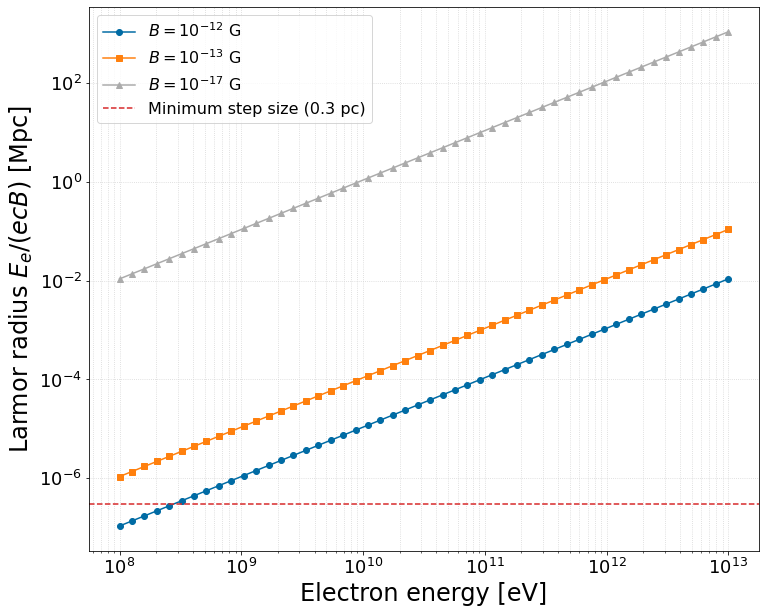

In [2]:
def get_larmor_radius(electron_energy_joules, magnetic_field_teslas):
    """Calculate Larmor radius using the equation in Section II of 
    https://arxiv.org/abs/2408.08818 : E_e/(e c B).
    Input parameters must be in SI units because astropy.constants are in SI units.
    
    Parameters
    ----------
    electron_energy_joules : array_like[float] or float
        Electron/positron energy in Joules.
    magnetic_field_teslas : float
        Magnetic field intensity in Teslas.
        
    Returns
    -------
    r_mpc : array_like[float] or float
        Larmor radius in Mpc
    """
    # Larmor radius in meters, E_e/(e c B)
    r_meters = electron_energy_joules / (constants.e.si * constants.c.si * magnetic_field_teslas)
    r_mpc = u.m.to(u.Mpc, r_meters)
    
    return r_mpc


def plot_larmor_radius_vs_energy(plot_interpolation=False):
    """Plot Larmor radius in Mpc vs electron/positron energy in eV.
    Note that for a given |B|, the Larmor radius is an upper limit due to 
    trilinear interpolation of the grid tending to decrease |B| by ~50% 
    (and always between 1-99%).
    """
    
    # Create electron energies in eV over the simulation energies which are tracked or injected
    # Minimum tracked energy is 1e8 eV
    energy_arr_ev = np.logspace(8, 13)
    
    # Magnetic field values under consideration in simulations
    b_gauss = [1e-12, 1e-13, 1e-17]
    # Dictionary to use for neater plot legend with LaTeX format
    b_gauss_dict = {1e-12: "$B = 10^{-12}$",
                    1e-13: "$B = 10^{-13}$", 
                    1e-15: "$B = 10^{-15}$", 
                    1e-17: "$B = 10^{-17}$"}
    
    # Interpolation has ROUGHLY the effect of decreasing the magnitude by 50%
    interpolation_factor = 0.5
    
    # Plot Larmor radius for each B field
    fig, ax = plt.subplots(1, 1)
    for i, b in enumerate(b_gauss):
        # Must convert to SI units
        b_tesla = u.G.to(u.T, b)
        line, = ax.plot(energy_arr_ev, get_larmor_radius(u.eV.to(u.J, energy_arr_ev), b_tesla), 
                marker=next(MARKERS), label=rf"{b_gauss_dict[b]} G")
        if i == 0 and plot_interpolation:
            # Add impact of interpolation to one line; only 1 so plot doesn't get cluttered
            ax.plot(energy_arr_ev, get_larmor_radius(u.eV.to(u.J, energy_arr_ev), b_tesla*interpolation_factor), 
                marker=next(MARKERS), color=line.get_color(), label=rf"Estimate of interpolated {b_gauss_dict[b]} G",
               alpha=0.5)
        
    ax.loglog()
    ax.axhline(u.pc.to(u.Mpc, 0.3), color="tab:red", ls="--", label="Minimum step size (0.3 pc)")
    ax.legend()
    ax.set_xlabel('Electron energy [eV]')
    ax.set_ylabel(r'Larmor radius $E_e/(ecB)$ [Mpc]')
    ax.minorticks_on() 
    plt.show()
    
    
plot_larmor_radius_vs_energy()